# ANALYSE

In [1]:
import pandas as pd
import numpy as np
import pylab

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
sns.set(color_codes=True)

from datetime import datetime

import scipy.stats as st
import statsmodels.api as sm

### Récupération des données nettoyées

In [2]:
df_principal = pd.read_csv('Export/export_nettoyage.csv', parse_dates=[6], low_memory=False)

In [3]:
# Je convertis les catégorie (float) en string
cat_to_str = df_principal['product_cat'].astype('str')

# Puis j'utilise .describe sur les catégories, les prix et l'âge des clients
# afin d'avoir une première visualisation rapide de ces éléments
print(f'''
Catégories des produits :
{cat_to_str.describe()}

Prix des produits :
{df_principal.product_price.describe()}

Âge des clients :
{df_principal.client_age.describe()}''')


Catégories des produits :
count     335193
unique         4
top          0.0
freq      209546
Name: product_cat, dtype: object

Prix des produits :
count    335172.000000
mean         17.199260
std          17.894739
min           0.620000
25%           8.580000
50%          13.790000
75%          18.990000
max         300.000000
Name: product_price, dtype: float64

Âge des clients :
count    335150.000000
mean         43.334435
std          13.518615
min          17.000000
25%          34.000000
50%          42.000000
75%          51.000000
max          93.000000
Name: client_age, dtype: float64


Sur la période, le CA est de 5 763 912.1€
Sur la période, il y a eu un total de 335 150 ventes.


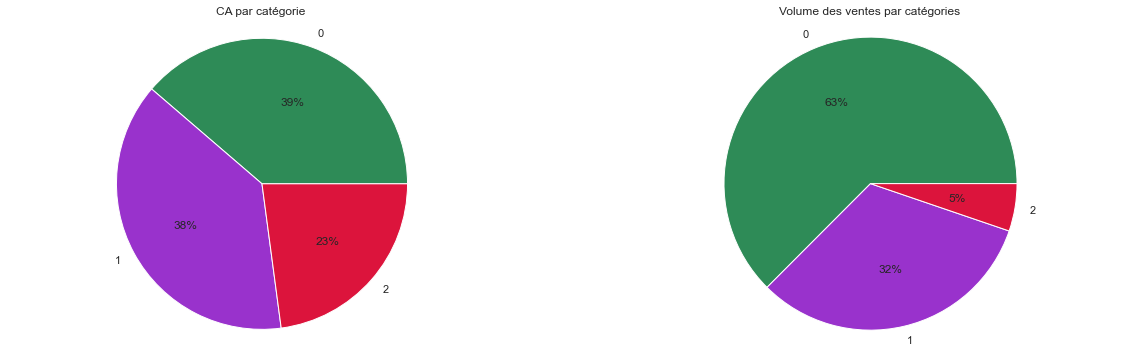

In [4]:
# Création du dataframe nous permettant de détérminer la répartition du CA et du volume de ventes par Catégorie de produit
df_ventes = df_principal.dropna(subset=['client_id', 'client_sex', 'client_birth', 'client_age', 'client_tranche_age', 'product_id', 'product_cat',
       'product_price', 'product_tranche_prix', 'transaction_sess_id', 'transaction_date', 'transaction_hour', 'transaction_weekday', 'transaction_month_part',
       'transaction_month', 'transaction_period_month'])

df_repartition = df_ventes[['product_cat', 'product_price']].groupby('product_cat').agg({'product_price': ['count', 'sum']}).reset_index()
df_repartition.columns = ['product_cat', 'volume', 'ca']
df_repartition['product_cat'] = df_repartition['product_cat'].astype('int32')

freqs = df_repartition.product_cat.value_counts()

# Puis on représente ces répartitions sous forme de camembert (ou pie chart)
print("Sur la période, le CA est de " + "{:,}".format(round(df_ventes.product_price.sum(),2)).replace(',', ' ') + "€")

plt.figure(figsize=(20,6)) # premier pie chart : répartition du CA par catégorie
plt.subplot(1,2,1)
plt.pie(df_repartition.ca, autopct='%1.0f%%', labels= freqs.index.values, colors= ['seagreen', 'darkorchid', 'crimson'])
plt.axis('equal')
plt.title('CA par catégorie')
plt.plot()
print("Sur la période, il y a eu un total de " + "{:,}".format(df_ventes.transaction_sess_id.count()).replace(',', ' ') + " ventes.")

plt.subplot(1,2,2) # second pie chart : répartition du volume de ventes par catégorie
plt.pie(df_repartition.volume, autopct='%1.0f%%', labels=freqs.index.values, colors= ['seagreen', 'darkorchid', 'crimson'])
plt.axis('equal')
plt.title('Volume des ventes par catégories')
plt.plot()

plt.savefig('Graphiques/part_ca_volume_par_cat.png') # J'enregistre ces graphiques

plt.show()

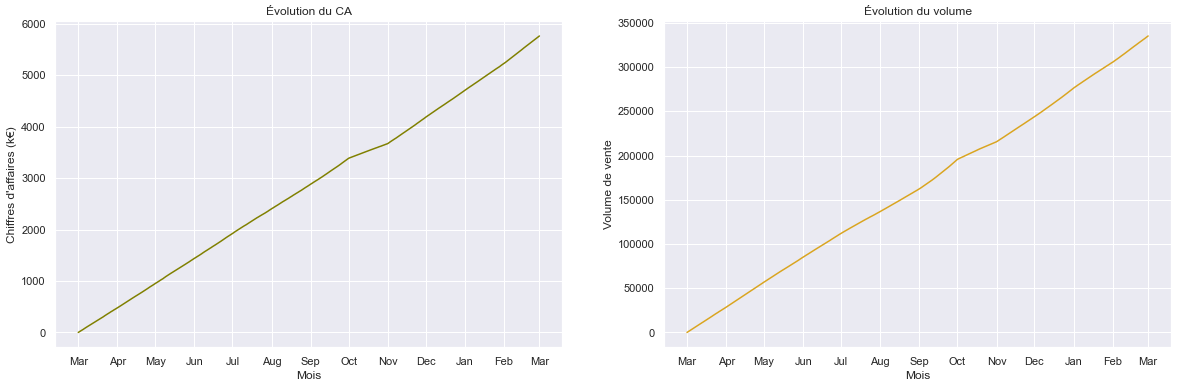

In [5]:
# Création du dataframe nous permettant de détérminer l'évolution du CA et du volume de ventes sur la période totale des données reçues
df_evol_ventes = df_ventes[['transaction_date', 'transaction_month', 'product_price']]
df_evol_ventes = df_evol_ventes.sort_values('transaction_date').reset_index()
df_evol_ventes['ca'] = (np.cumsum(df_evol_ventes.product_price))*0.001
df_evol_ventes['volume'] = pd.Series(range(len(df_evol_ventes))) + 1

plt.figure(figsize=(20,6))
# premiere courbe : évolution du CA
plt.subplot(1,2,1) 
plt.plot(df_evol_ventes['transaction_date'], df_evol_ventes['ca'], color='olive')
plt.title('Évolution du CA')
plt.xticks(['2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03'],
['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar'])
plt.xlabel('Mois')
plt.ylabel("Chiffres d'affaires (k€)")
# seconde courbe : évolution du volume des ventes
plt.subplot(1,2,2)  
plt.plot(df_evol_ventes['transaction_date'], df_evol_ventes['volume'], color='goldenrod')
plt.title('Évolution du volume')
plt.xticks(['2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03'],
['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar'])
plt.xlabel('Mois')
plt.ylabel('Volume de vente')

plt.savefig('Graphiques/evol_ca_volume_par_mois.png') # J'enregistre ces graphiques

plt.show()


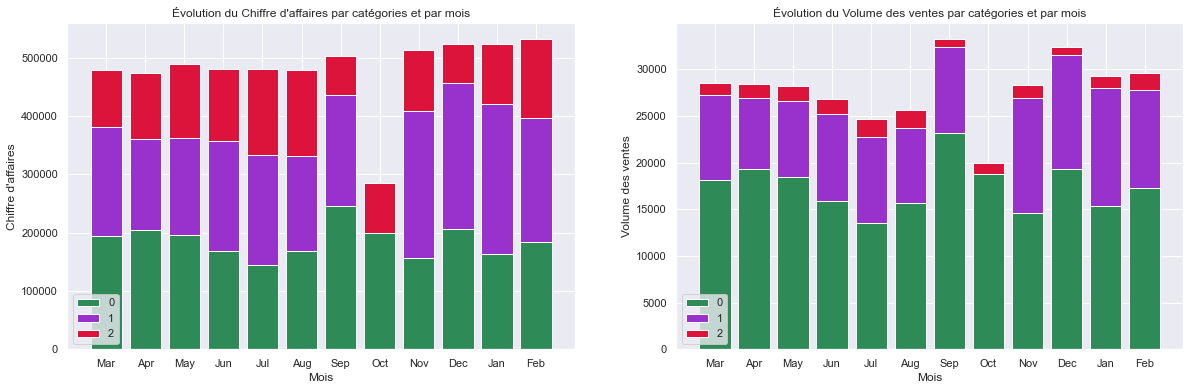

In [6]:
cat_names = np.sort(df_ventes.product_cat.unique().astype('int32'))
    
# on calcule un df qui contient l'unité de temps, la cat, et le prix
df = df_ventes[['transaction_period_month', 'product_cat', 'product_price']].groupby(['transaction_period_month', 'product_cat']).agg({'product_price':['sum', 'count']}).reset_index()
df.columns = ['transaction_period_month', 'product_cat', 'ca', 'volume']
    
# on determine les valeurs de temps en x
x = df['transaction_period_month'].sort_values().unique()

# pour chaque categories, on calcul les valeurs de ca et de volume des ventes
cat_vals = []
for cat in cat_names:
    ca = df[df.product_cat == cat].sort_values('transaction_period_month').ca.values
    volume = df[df.product_cat == cat].sort_values('transaction_period_month').volume.values
    cat_vals.append({'cat_name': cat, "Chiffre d'affaires": ca, 'Volume des ventes': volume})

# Ajout du mois d'Octobre pour la catégorie 1 (à 0 de ca et 0 de volume)
# (car ce mois a été supprimé lors du nettoyage des données pour faire face à l'absence de certaines données)
cat_vals[1]["Chiffre d'affaires"] = np.insert(cat_vals[1]["Chiffre d'affaires"],7,0)
cat_vals[1]['Volume des ventes'] = np.insert(cat_vals[1]['Volume des ventes'],7,0)

plt.figure(figsize=(20,6))

for k, element in enumerate(["Chiffre d'affaires", 'Volume des ventes']):
    plt.subplot(1,2,k+1)
    # pour le ca, puis le volume, on genere le graphique en bar
    colors = ['seagreen', 'darkorchid', 'crimson']
    for i, cat in enumerate(cat_names):
        plt.bar(x, cat_vals[cat][element], 
                color=colors[i],
                label=cat_vals[cat]['cat_name'],
                bottom = np.sum([cat_vals[j][element] for j in range(i)], axis=0))
    plt.xticks([3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.],['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb'])
    plt.xlabel('Mois')
    plt.ylabel(element)
    plt.legend(loc='lower left')
    plt.title(f"Évolution du {element} par catégories et par mois")

plt.savefig('Graphiques/ca_volume_par_cat_mois.png') # J'enregistre ces graphiques

plt.show()

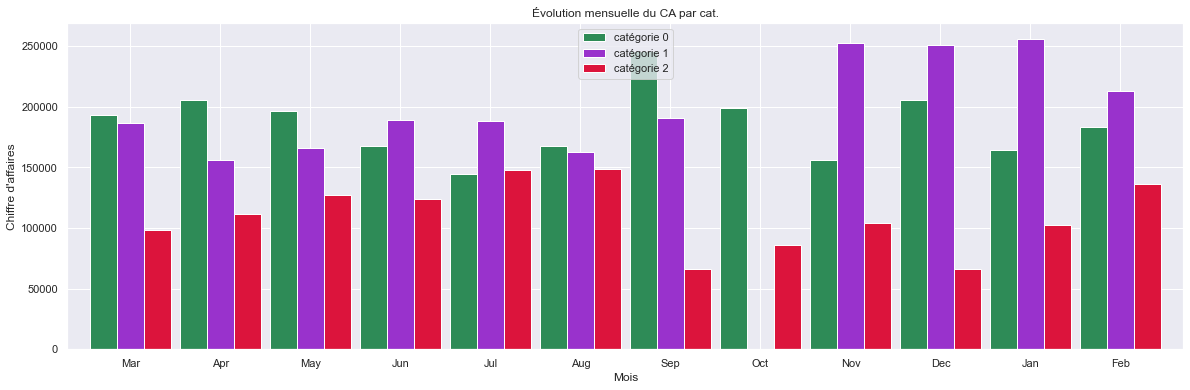

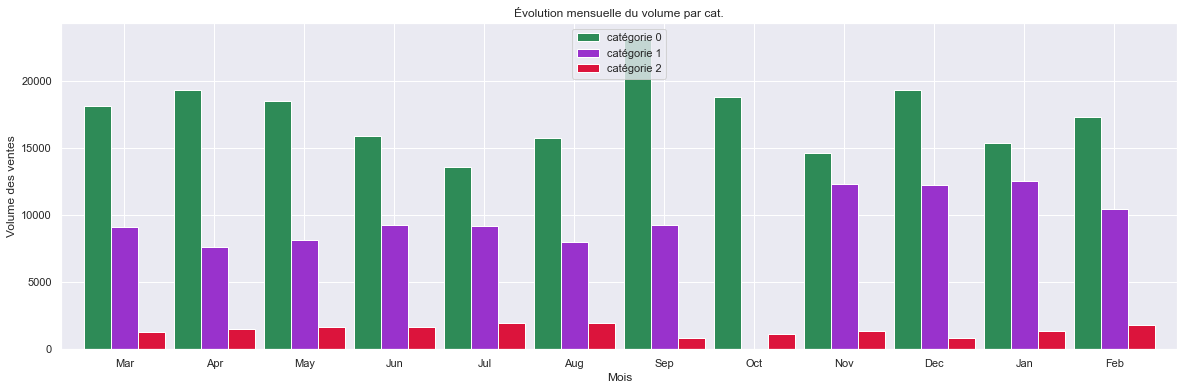

In [7]:
# Création du dataframe nous permettant de détérminer l'évolution du CA et du volume de ventes par catégorie
df_month_evol = df_ventes[['product_cat', 'product_price', 'transaction_period_month']]
df_month_evol = pd.pivot_table(df_month_evol, index='transaction_period_month', columns=['product_cat'], aggfunc=['sum', 'count']).reset_index()
df_month_evol.columns = ['transaction_period_month', 'ca_0', 'ca_1', 'ca_2', 'volume_0', 'volume_1', 'volume_2']

# On trace le graphique de l'évolution du CA par catégorie
df_month_evol[['ca_0', 'ca_1', 'ca_2']].plot.bar(
    figsize=(20,6), 
    width=0.9, 
    color=['seagreen', 'darkorchid', 'crimson']
)
plt.legend(['catégorie 0', 'catégorie 1', 'catégorie 2'], loc='upper center')
plt.title('Évolution mensuelle du CA par cat.')
plt.xlabel('Mois')
plt.ylabel("Chiffre d'affaires")
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb'])
plt.xticks(rotation=0)

plt.savefig('Graphiques/evol_ca_cat_par_mois.png') # J'enregistre le graphique

# On trace le graphique de l'évolution du volume des ventes par catégorie
df_month_evol[['volume_0', 'volume_1', 'volume_2']].plot.bar(
    figsize=(20,6), 
    width=0.9, 
    color=['seagreen', 'darkorchid', 'crimson']
)
plt.legend(['catégorie 0', 'catégorie 1', 'catégorie 2'], loc='upper center')
plt.title('Évolution mensuelle du volume par cat.')
plt.xlabel('Mois')
plt.ylabel("Volume des ventes")
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb'])
plt.xticks(rotation=0)

plt.savefig('Graphiques/evol_volume_cat_par_mois.png') # J'enregistre le graphique

0.67% des produits sont invendus.


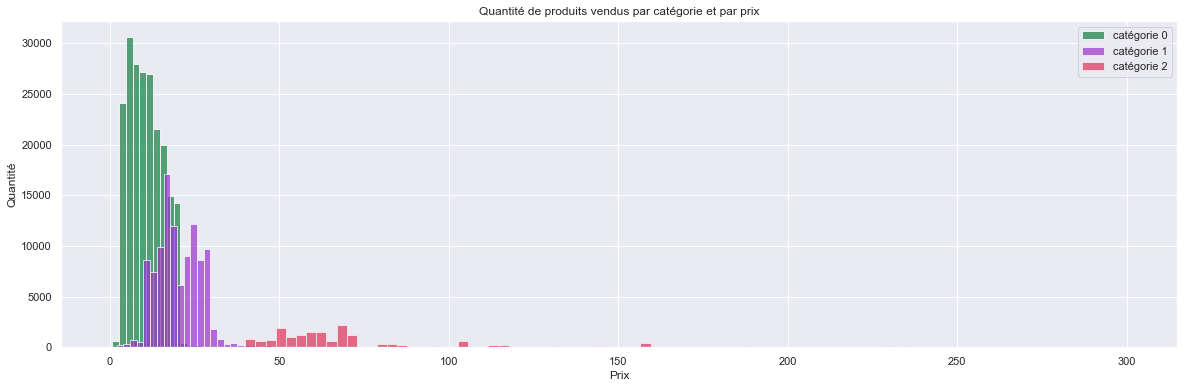

In [8]:
# Création du dataframe nous permettant de détérminer la quantité de produits vendus par prix et par catégorie
produits_invendus_id = df_principal.loc[df_principal.client_id.isnull(), 'product_id'].unique()
df_produits_invendus = df_principal.loc[df_principal['product_id'].isin(produits_invendus_id), ['product_id', 'product_cat', 'product_price', 'product_tranche_prix']]
df_produits_vendus = df_ventes.loc[:, 'product_id':'product_tranche_prix'].drop_duplicates()

print(f"{df_produits_invendus['product_id'].unique().shape[0] / (df_produits_vendus['product_id'].unique().shape[0] + df_produits_invendus['product_id'].unique().shape[0]) * 100 :.2f}% des produits sont invendus.")

# On classe les prix par catégorie dans la liste suivante :
cat_prices = {
    cat: df_produits_vendus.loc[
            (df_produits_vendus.product_cat==cat)
          & (df_produits_vendus.product_price),
        'product_price'
        ]
    for cat in [0,1,2]}

# Puis on trace le graphique à partir de la liste générée
plt.figure(figsize=(20,6))
plt.hist(cat_prices[0], bins=20, alpha=0.8, color='seagreen')
plt.hist(cat_prices[1], bins=40, alpha=0.7, color='darkorchid')
plt.hist(cat_prices[2], bins=90, alpha=0.6, color='crimson')
plt.legend(['catégorie 0', 'catégorie 1', 'catégorie 2'])
plt.xlabel('Prix')
plt.ylabel('Quantité')
plt.title('Quantité de produits vendus par catégorie et par prix')
plt.plot()
plt.savefig('Graphiques/volume_vente_cat_prix.png')

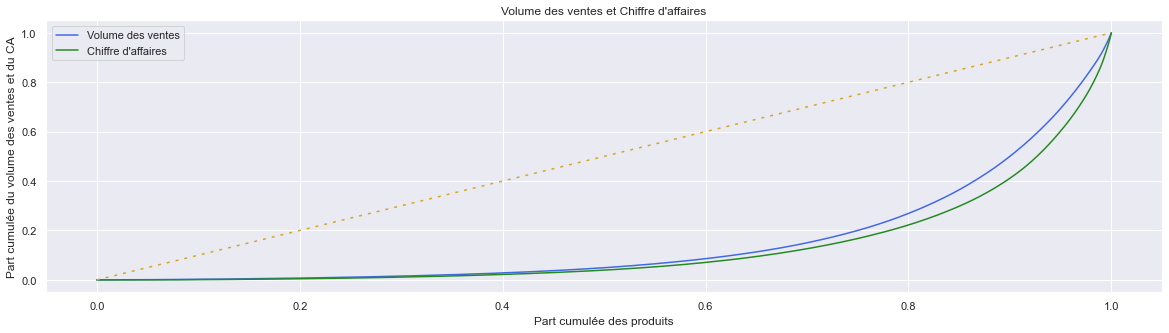

Indice de gini sur le volume de ventes: 0.69
Indice de gini sur le chiffre d'affaire: 0.74

73% des ventes sont faites sur 20% des produits (653 produits) et
20% des produits (soit 653 produits) rapportent 78% du CA donc
73% des ventes rapportent 78% du CA.


In [9]:
# Création du dataframe nous permettant de tracer les courbes de Lorenz concernant le volume des ventes et le chiffre d'affaires
temp = df_ventes[['product_id', 'product_price']].groupby('product_id').agg({
    'product_price': ['count', 'sum']
}).reset_index()
temp.columns = ['product_id', 'transaction_number', 'ca']

transaction_vol = temp['transaction_number'].values
transaction_ca = temp['ca'].values
lorenz_vol = np.cumsum(np.sort(transaction_vol)) / transaction_vol.sum()
lorenz_vol = np.append([0], lorenz_vol)
lorenz_ca = np.cumsum(np.sort(transaction_ca)) / transaction_ca.sum()
lorenz_ca = np.append([0], lorenz_ca)

# On trace le graphique
plt.figure(figsize=(20,5))
plt.plot(np.linspace(0,1,len(lorenz_vol)), lorenz_vol, color="royalblue")
plt.plot(np.linspace(0,1,len(lorenz_ca)), lorenz_ca, color="forestgreen")
plt.plot(np.linspace(0,1,len(lorenz_vol)), np.linspace(0,1,len(lorenz_vol)), dashes=[2,4], color='goldenrod')
plt.xlabel('Part cumulée des produits')
plt.ylabel('Part cumulée du volume des ventes et du CA')
plt.title("Volume des ventes et Chiffre d'affaires")
plt.legend(["Volume des ventes", "Chiffre d'affaires"])
plt.savefig('Graphiques/volume_ventes_ca_lorenz.png') # J'enregistre le graphique
plt.show()

# On calcul l'indice de gini pour le volume des ventes
aire_ss_courbe_vol = lorenz_vol[:-1].sum() / len(lorenz_vol)
S_vol = 0.5 - aire_ss_courbe_vol
gini_vol = 2*S_vol
# même chose pour le chiffre d'affaires
aire_ss_courbe_ca = lorenz_ca[:-1].sum() / len(lorenz_ca)
S_ca = 0.5 - aire_ss_courbe_ca
gini_ca = 2*S_ca
# Puis on les affiche
print(f'''Indice de gini sur le volume de ventes: {gini_vol:.2f}
Indice de gini sur le chiffre d'affaire: {gini_ca:.2f}''')

# Calcul et affichage de mon intérprétation du graphique (loi des 80/20)
produits_plus_vendus = temp[['product_id', 'transaction_number']].sort_values('transaction_number', ascending=False)[:round(len(temp)*0.2)]
prct_prod =  produits_plus_vendus.product_id.count() / temp.product_id.count() * 100
prct_ventes = produits_plus_vendus.transaction_number.sum() / temp.transaction_number.sum() * 100
produits_plus_rtbles = temp[['product_id', 'ca']].sort_values('ca', ascending=False)[:round(len(temp)*0.2)]
nb_prod = len(produits_plus_rtbles)
prct_prod =  produits_plus_rtbles.product_id.count() / temp.product_id.count() * 100
prct_ca = produits_plus_rtbles.ca.sum() / temp.ca.sum() * 100

print(f'''
{prct_ventes:.0f}% des ventes sont faites sur {prct_prod:.0f}% des produits ({len(produits_plus_vendus)} produits) et
{prct_prod:.0f}% des produits (soit {nb_prod} produits) rapportent {prct_ca:.0f}% du CA donc
{prct_ventes:.0f}% des ventes rapportent {prct_ca:.0f}% du CA.''')


Il existe 5734 valeurs abérrantes (soit 1.71% du total des valeurs):
- 428 valeurs pour la catégorie 0
- 2177 valeurs pour la catégorie 1
- 3129 valeurs pour la catégorie 2



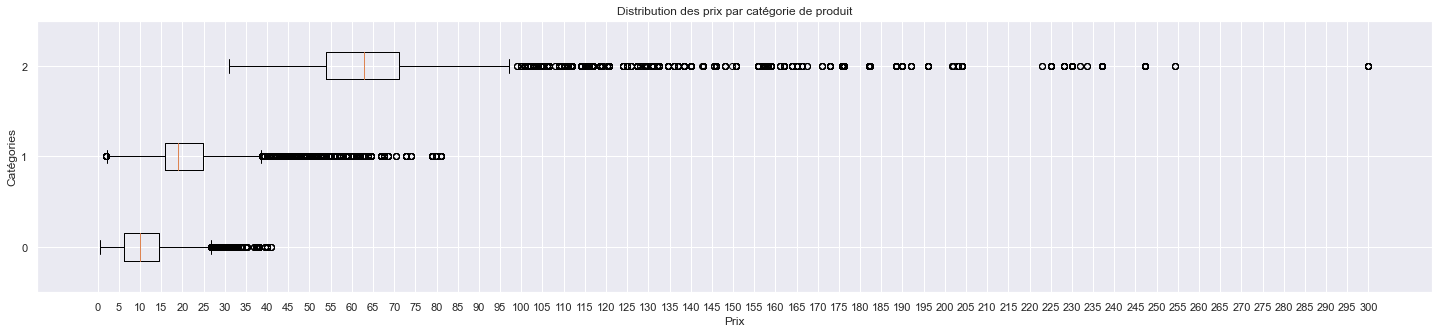

In [10]:
# Création du dataframe nous permettant de tracer le graphique représentant la distribution des prix des produits selon leur catégorie
prix_cat0 = df_ventes['product_price'].loc[(df_ventes.product_cat == 0)]
prix_cat1 = df_ventes['product_price'].loc[(df_ventes.product_cat == 1)]
prix_cat2 = df_ventes['product_price'].loc[(df_ventes.product_cat == 2)]
prix_par_cat = [prix_cat0,prix_cat1,prix_cat2]

# Ce bloc permet d'établir combien d'outliers (point en dehors des boxplots) il existe, par catégorie
IQR_cat0 = prix_cat0.quantile(0.75) - prix_cat0.quantile(0.25)
IQR_cat1 = prix_cat1.quantile(0.75) - prix_cat1.quantile(0.25)
IQR_cat2 = prix_cat2.quantile(0.75) - prix_cat2.quantile(0.25)
upper_bound_cat0 = prix_cat0.quantile(0.75) + (IQR_cat0 * 1.5)
upper_bound_cat1 = prix_cat1.quantile(0.75) + (IQR_cat1 * 1.5)
upper_bound_cat2 = prix_cat2.quantile(0.75) + (IQR_cat2 * 1.5)
lower_bound_cat1 = prix_cat1.quantile(0.25) - (IQR_cat1 * 1.5)
outliers_cat0 = prix_cat0.loc[(prix_cat0 > upper_bound_cat0)].count()
outliers_cat1 = prix_cat1.loc[(prix_cat1 < lower_bound_cat1)|(prix_cat1 > upper_bound_cat1)].count()
outliers_cat2 = prix_cat2.loc[(prix_cat2 > upper_bound_cat2)].count()
# J'affiche ensuite le résultat des calculs ci-dessus
print(f'''
Il existe {outliers_cat0 + outliers_cat1 + outliers_cat2} valeurs abérrantes (soit {round(((outliers_cat0 + outliers_cat1 + outliers_cat2)/(prix_cat0.count() + prix_cat1.count() + prix_cat2.count())*100),2)}% du total des valeurs):
- {outliers_cat0} valeurs pour la catégorie 0
- {outliers_cat1} valeurs pour la catégorie 1
- {outliers_cat2} valeurs pour la catégorie 2
''')

# Enfin, on trace le graphique
plt.figure(figsize=(25,5))
plt.boxplot(prix_par_cat, vert=False)
pylab.yticks([1,2,3], cat_names)
plt.ylabel('Catégories')
plt.xlabel('Prix')
plt.xticks(np.arange(0, 305, step=5))
plt.title("Distribution des prix par catégorie de produit")
plt.savefig('Graphiques/distribution_prix_par_categories.png') # J'enregistre le graphique
plt.show()

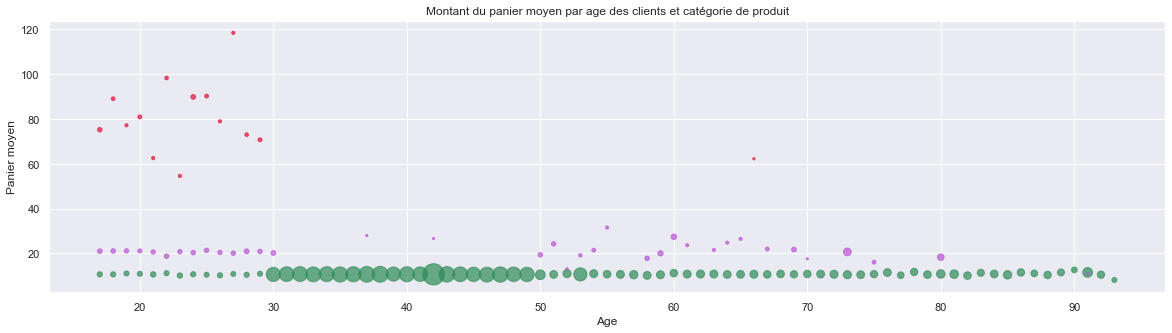

In [11]:
# Création du dataframe permettant de tracer le graphique représentant la distribution du montant du panier moyen et du nombre de transacton en fonction de l'age des clients
nb_transaction_by_client = df_ventes.groupby(['client_id', 'product_cat']).count().reset_index()
nb_transaction_by_client = nb_transaction_by_client[['client_id','product_cat','transaction_sess_id']]
sum_price_by_client = df_ventes.groupby(['client_id','product_cat']).sum().reset_index()
sum_price_by_client = sum_price_by_client[['client_id','product_cat','product_price']]

info_transaction_client = pd.merge(nb_transaction_by_client, sum_price_by_client, on=['client_id','product_cat'])
info_panier_moyen = pd.merge(info_transaction_client, df_ventes, on='client_id')
info_panier_moyen = info_panier_moyen[['client_id', 'product_cat_x','transaction_sess_id_x', 'product_price_x', 'client_age','client_tranche_age']]
info_panier_moyen.drop_duplicates(subset ="client_id", keep = 'first', inplace=True)
info_panier_moyen['panier_moyen'] = info_panier_moyen['product_price_x'] / info_panier_moyen['transaction_sess_id_x']

info_panier_moyen = info_panier_moyen.groupby(['client_age','product_cat_x']).mean().reset_index()

# Ci-dessous, je créé une colonne supplémentaire à mon dataframe
# afin d'associer une couleur à chaque catégorie (pour une meilleure compréhension du graphique)
pd.set_option('mode.chained_assignment', None)
info_panier_moyen['couleur'] = ''
for i in info_panier_moyen.index :
    if info_panier_moyen['product_cat_x'][i] == 0 :
        info_panier_moyen['couleur'][i] = 'seagreen'
    elif info_panier_moyen['product_cat_x'][i] == 1 :
        info_panier_moyen['couleur'][i] = 'mediumorchid'
    else :
        info_panier_moyen['couleur'][i] = 'crimson'
pd.set_option('mode.chained_assignment', 'raise')

# Je trace le graphique (nuage de points)
plt.figure(figsize=(20,5))
plt.scatter(info_panier_moyen['client_age'],
    info_panier_moyen['panier_moyen'],
    c=info_panier_moyen['couleur'],
    s=info_panier_moyen['transaction_sess_id_x']*5,
    alpha=0.7)
plt.title("Montant du panier moyen par age des clients et catégorie de produit")
plt.ylabel('Panier moyen')
plt.xlabel('Age')
plt.savefig('Graphiques/panier_moy_par_age-et-cat.png') # J'enregistre le graphique
plt.show()

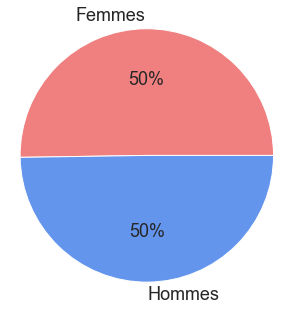

In [12]:
# Ici, je trace la répartion des clients selon leur genre
plt.figure(figsize=(5,5))
plt.pie(df_ventes.client_sex.value_counts(), autopct=lambda x:f'{x:.0f}%',labels=['Femmes', 'Hommes'], 
        textprops={'fontsize': 18}, colors= ['lightcoral', 'cornflowerblue'])

plt.axis('equal')
plt.savefig('Graphiques/repartition_F-H.png')
plt.show()


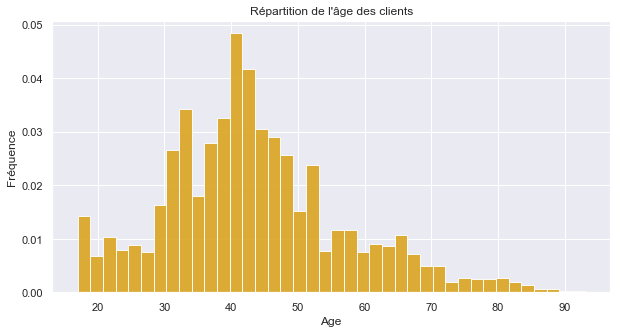

In [13]:
# Enfin, il me semblait pertinent de connaitre la répartion des clients selon leur âge.
# Je trace donc un histogramme
ages_ss_18 = df_ventes['client_age']
plt.figure(figsize=(10,5))
plt.hist(ages_ss_18, density=True, bins=40, alpha=0.9, color='goldenrod')
plt.title('Répartition de l\'âge des clients')
plt.xlabel('Age')
plt.ylabel('Fréquence')
plt.savefig('Graphiques/repartition_age_client.png')
plt.show()